In [1]:
import os
import math
import json
import time
import joblib
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from scipy.sparse import *
from IPython.display import Markdown, display
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
plt.style.use('seaborn')

In [3]:
def printmd(string):
    display(Markdown(string))

### Import dataset

In [4]:
electronics=pd.read_csv("ratings_Electronics.csv",names=['UserId', 'Asin','Rating','Timestamp'])

In [5]:
electronics.head()

,UserId,Asin,Rating,Timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [6]:
electronics.shape

(7824482, 4)

In [7]:
new_electronics=electronics.iloc[:500000,0:]
new_electronics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 4 columns):
UserId       500000 non-null object
Asin         500000 non-null object
Rating       500000 non-null float64
Timestamp    500000 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 15.3+ MB


In [8]:
new_dataset = new_electronics.drop(['Timestamp'],axis=1)

In [9]:
new_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 3 columns):
UserId    500000 non-null object
Asin      500000 non-null object
Rating    500000 non-null float64
dtypes: float64(1), object(2)
memory usage: 11.4+ MB


## Data Anslysis for various pupose

In [10]:
mean_of_rating = np.mean(list(new_electronics['Rating']))

In [11]:
mean_of_rating

3.987012

In [12]:
np.median(list(new_electronics['Rating']))

5.0

In [13]:
#missing values
print('Number of missing values across columns: \n',new_dataset.isnull().sum())

Number of missing values across columns: 
 UserId    0
Asin      0
Rating    0
dtype: int64


#### Rating Distribution

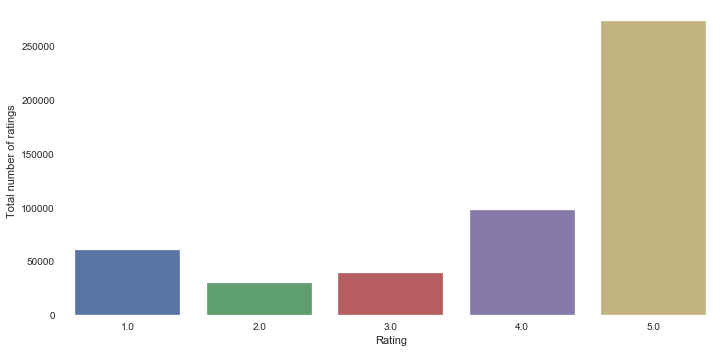

In [14]:
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=new_dataset, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")
    
plt.show()

#### Unique Users and products

In [15]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",new_dataset.shape[0])
print("Total No of Users   :", len(np.unique(new_dataset.UserId)))
print("Total No of products  :", len(np.unique(new_dataset.Asin)))

Total data 
--------------------------------------------------

Total no of ratings : 500000
Total No of Users   : 404347
Total No of products  : 30667


#### Most Contributed User

In [16]:
no_of_rated_products_per_user = new_dataset.groupby(by='UserId')['Rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

UserId
A5JLAU2ARJ0BO     296
A231WM2Z2JL0U3    247
A25HBO5V8S8SEA    155
AKT8TGIT6VVZ5      86
AT6CZDCP4TRGA      79
Name: Rating, dtype: int64

In [17]:
no_of_rated_products_per_user.describe()

count    404347.000000
mean          1.236562
std           1.191909
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         296.000000
Name: Rating, dtype: float64

In [18]:
printmd(f'**No of rated product more than 5 per user : {sum(no_of_rated_products_per_user >= 5)}**' )

**No of rated product more than 5 per user : 4267**

## Getting the new dataframe with users who has given 5 or more ratings

### for better result

In [19]:
new_df=new_dataset.groupby("UserId").filter(lambda x:x['Rating'].count() >=5)

In [20]:
new_df.head(n=10)

,UserId,Asin,Rating
6,A3J3BRHTDRFJ2G,0511189877,2.0
118,AT09WGFUM934H,0594481813,3.0
178,A17HMM1M7T9PJ1,0970407998,4.0
189,A2IDCSC6NVONIZ,0972683275,5.0
295,A23A7OH3AM0PDA,0972683275,4.0
389,A6J8D9V5S9MBE,0972683275,5.0
406,A39Z4OU2C7ENWH,0972683275,3.0
631,A3TAS1AG6FMBQW,0972683275,5.0
886,AZFF4CX9MQ4AE,0972683275,5.0
889,A2HI35H2BOCV9R,0972683275,3.0


In [21]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33433 entries, 6 to 499978
Data columns (total 3 columns):
UserId    33433 non-null object
Asin      33433 non-null object
Rating    33433 non-null float64
dtypes: float64(1), object(2)
memory usage: 1.0+ MB


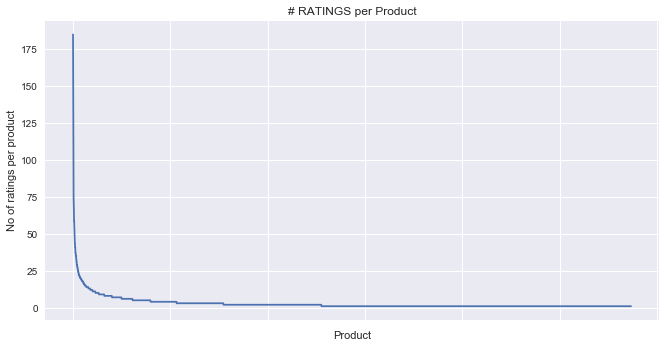

In [22]:
no_of_ratings_per_product = new_df.groupby(by='Asin')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

### Model-based collaborative filtering system

In [23]:
ratings_matrix = new_df.pivot_table(values='Rating', index='UserId', columns='Asin', fill_value=0)

In [24]:
ratings_matrix.shape

(4267, 11471)

In [25]:
X = ratings_matrix.T
X.head()

UserId,A100UD67AHFODS,A100WO06OQR8BQ,A101OAAMZYWQ3U,A1027EV8A9PV1O,A1029ESOR657OQ,A102EC3XGCBZ81,A105GWGM7PDAI2,A105TOJ6LTVMBG,A108H0RI2LWLUO,A108XABRHAA9E7,...,AZQ7O73EAS3VI,AZQ8HGO3Z4T,AZQUJWF2SBRP9,AZRJH4JFB59VC,AZTAC5WZ4QDRN,AZV2U6GU5QA6C,AZX7GJRLMWN92,AZYF51H72BLLZ,AZYJE40XW6MFG,AZZ2DEE2NTIM7
Asin,,,,,,,,,,,,,,,,,,,,,
0511189877,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0594481813,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0970407998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0972683275,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
from sklearn.decomposition import TruncatedSVD

In [27]:
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(11471, 10)

In [28]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(11471, 11471)

In [29]:
correlation_matrix

array([[ 1.        ,  0.94752624,  0.20527097, ..., -0.14248879,
         0.16477905,  0.1213853 ],
       [ 0.94752624,  1.        ,  0.32959705, ..., -0.04680091,
         0.3820747 ,  0.3411209 ],
       [ 0.20527097,  0.32959705,  1.        , ...,  0.30233689,
         0.16405773,  0.00997293],
       ...,
       [-0.14248879, -0.04680091,  0.30233689, ...,  1.        ,
         0.34431777,  0.56330391],
       [ 0.16477905,  0.3820747 ,  0.16405773, ...,  0.34431777,
         1.        ,  0.77288564],
       [ 0.1213853 ,  0.3411209 ,  0.00997293, ...,  0.56330391,
         0.77288564,  1.        ]])

In [36]:
X.index[4]

'1400501466'

In [37]:
i = "1400501466"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

4

In [38]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(11471,)

In [39]:
Recommend = list(X.index[correlation_product_ID > 0.85])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:24]

['0594481813',
 '1400532736',
 '9625993428',
 'B000000O2F',
 'B000001OKH',
 'B000001OMJ',
 'B000001OMT',
 'B000001OMV',
 'B000001ON0',
 'B00000J055',
 'B00000J1F3',
 'B00000J1QK',
 'B00000J1UA',
 'B00000J47V',
 'B00000J4DT',
 'B00000J4E4',
 'B00000J4GE',
 'B00000JBHE',
 'B00000JBPN',
 'B00000K2YR',
 'B00000K2ZO',
 'B00000K3QL',
 'B00000K3RG',
 'B00001MXWD']

In [40]:
len(Recommend)

544